## Multimodal Training Sequential

Predict horizon boundaries from full images and geo-temporal infos. Afterwards, predict morphological features and symbol for every horizon

In [2]:
# Vipin/Teo
import os
#os.chdir("/storage/projects/BGR Soil")
os.chdir("../../../")
!pwd

/mnt/KInsektDaten/teo


In [3]:
import os
import pickle

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_  # modifies the tensors in-place (vs clip_grad_norm)
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

pd.set_option("display.max_columns", None)
np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
import sys
sys.path.append('./BGR')
from bgr.soil.data.datasets import ImageTabularDataset
from bgr.soil.data.horizon_tabular_data import HorizonDataProcessor
import bgr.soil.modelling.general_models as bgr_mod
from bgr.soil.callbacks import EarlyStopping, ModelCheckpoint
from bgr.soil.transforms import VerticalStripeCrop
from bgr.soil.metrics import DepthMarkerLoss, TopKHorizonAccuracy
from bgr.soil.utils import pad_tensor

### Data Loading

In [5]:
dataprocessor = HorizonDataProcessor(label_embeddings_path='./BGR/label_embeddings/all_horizons_embeddings.pickle')
df = dataprocessor.load_processed_data()

train_df, val_df, test_df = dataprocessor.multi_label_stratified_shuffle_split(df, train_val_test_frac=[0.6, 0.2, 0.2], random_state=2025)

/mnt/KInsektDaten/teo/./BGR/bgr/soil/data/horizon_tabular_data.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GrundwaStand'] = df['GrundwaStand'].str.replace('>', '').astype(float)
/mnt/KInsektDaten/teo/./BGR/bgr/soil/data/horizon_tabular_data.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ycoord'] = df['ycoord'].astype(float)
/mnt/KInsektDaten/teo/./BGR/bgr/soil/data/horizon_tabular_data.py:375: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a fu

In [6]:
df

,index,Probenahme_Monat_0,Probenahme_Monat_1,Probenahme_Monat_2,Probenahme_Monat_3,Probenahme_Monat_4,Probenahme_Monat_5,Probenahme_Monat_6,Probenahme_Monat_7,Probenahme_Monat_8,Probenahme_Monat_9,Probenahme_Monat_10,Probenahme_Monat_11,Probenahme_Jahr_0,Probenahme_Jahr_1,Probenahme_Jahr_2,Probenahme_Jahr_3,Probenahme_Jahr_4,Probenahme_Jahr_5,Probenahme_Jahr_6,Probenahme_Jahr_7,xcoord,ycoord,Bodenklimaraum_Name_0,Bodenklimaraum_Name_1,Bodenklimaraum_Name_2,Bodenklimaraum_Name_3,Bodenklimaraum_Name_4,Bodenklimaraum_Name_5,Bodenklimaraum_Name_6,Bodenklimaraum_Name_7,Bodenklimaraum_Name_8,Bodenklimaraum_Name_9,Bodenklimaraum_Name_10,Bodenklimaraum_Name_11,Bodenklimaraum_Name_12,Bodenklimaraum_Name_13,Bodenklimaraum_Name_14,Bodenklimaraum_Name_15,Bodenklimaraum_Name_16,Bodenklimaraum_Name_17,Bodenklimaraum_Name_18,Bodenklimaraum_Name_19,Bodenklimaraum_Name_20,Bodenklimaraum_Name_21,Bodenklimaraum_Name_22,Bodenklimaraum_Name_23,Bodenklimaraum_Name_24,Bodenklimaraum_Name_25,Bodenklimaraum_Name_26,Bodenklimaraum_Name_27,Bodenklimaraum_Name_28,Bodenklimaraum_Name_29,Bodenklimaraum_Name_30,Bodenklimaraum_Name_31,Bodenklimaraum_Name_32,Bodenklimaraum_Name_33,Bodenklimaraum_Name_34,Bodenklimaraum_Name_35,Bodenklimaraum_Name_36,Bodenklimaraum_Name_37,Bodenklimaraum_Name_38,Bodenklimaraum_Name_39,Bodenklimaraum_Name_40,Bodenklimaraum_Name_41,Bodenklimaraum_Name_42,Bodenklimaraum_Name_43,Bodenklimaraum_Name_44,Bodenklimaraum_Name_45,Bodenklimaraum_Name_46,Bodenklimaraum_Name_47,Bodenklimaraum_Name_48,Bodenklimaraum_Name_49,Landnutzung_0,Landnutzung_1,Landnutzung_2,BZE_Moor_0,BZE_Moor_1,Hauptbodentyp_0,Hauptbodentyp_1,Hauptbodentyp_2,Hauptbodentyp_3,Hauptbodentyp_4,Hauptbodentyp_5,Hauptbodentyp_6,Hauptbodentyp_7,Hauptbodentyp_8,Hauptbodentyp_9,Hauptbodentyp_10,Hauptbodentyp_11,Hauptbodentyp_12,Hauptbodentyp_13,Hauptbodentyp_14,Hauptbodentyp_15,Hauptbodentyp_16,Hauptbodentyp_17,Hauptbodentyp_18,Hauptbodentyp_19,Hauptbodentyp_20,Hauptbodentyp_21,Hauptbodentyp_22,Hauptbodentyp_23,Hauptbodentyp_24,Hauptbodentyp_25,Hauptbodentyp_26,Hauptbodentyp_27,Hauptbodentyp_28,Hauptbodentyp_29,Hauptbodentyp_30,Hauptbodentyp_31,Hauptbodentyp_32,Hauptbodentyp_33,Hauptbodentyp_34,Hauptbodentyp_35,Hauptbodentyp_36,Hauptbodentyp_37,GrundwaStufe_0.0,GrundwaStufe_1.0,GrundwaStufe_2.0,GrundwaStufe_3.0,GrundwaStufe_4.0,GrundwaStufe_5.0,GrundwaStufe_6.0,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung_0.0,Neigung_1.0,Neigung_2.0,Neigung_3.0,Neigung_4.0,Neigung_5.0,Neigung_6.0,Exposition_0.0,Exposition_1.0,Exposition_2.0,Exposition_3.0,Exposition_4.0,Exposition_5.0,Exposition_6.0,Exposition_7.0,Exposition_8.0,Woelbung_0.0,Woelbung_1.0,Woelbung_2.0,Woelbung_3.0,Woelbung_4.0,Woelbung_5.0,Woelbung_6.0,Woelbung_7.0,Woelbung_8.0,Reliefformtyp_0.0,Reliefformtyp_1.0,Reliefformtyp_2.0,Reliefformtyp_3.0,Reliefformtyp_4.0,Reliefformtyp_5.0,Reliefformtyp_6.0,Reliefformtyp_7.0,LageImRelief_0.0,LageImRelief_1.0,LageImRelief_2.0,LageImRelief_3.0,LageImRelief_4.0,LageImRelief_5.0,LageImRelief_6.0,LageImRelief_7.0,LageImRelief_8.0,LageImRelief_9.0,KV_0_30,KV_30_100,file,Untergrenze,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Horizontsymbol_relevant
0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0.844599,0.831262,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,1.0,0.0,0.0,False,True,False,False,False,False,False,False,True,False,False,False,Fal

In [7]:
exploded_df = df.explode('Karbonat')
exploded_df = exploded_df.explode('Humusgehaltsklasse')  # Apply on the updated DataFrame
exploded_df = exploded_df.explode('Durchwurzelung')      # Apply on the updated DataFrame

# Used for constructing the tabular predictors in the general model
# For every tabular feature name, specify the output dimension and if it's a classification task
tabular_predictors_dict = {
    'Soil_Type_Predictor':  {'output_dim': max(df['Bodenart'].apply(max)),           'classification': True},
    'Soil_Color_Predictor': {'output_dim': max(df['Bodenfarbe'].apply(max)),         'classification': True},
    'Stones_Predictor':     {'output_dim': 1,                                      'classification': False},
    'Carbonate_Predictor':  {'output_dim': max(df['Karbonat'].apply(max)),           'classification': True},
    'Humus_Predictor':      {'output_dim': max(df['Humusgehaltsklasse'].apply(max)), 'classification': True},
    'Rooting_Predictor':    {'output_dim': max(df['Durchwurzelung'].apply(max)),     'classification': True}
}

tabular_predictors_dict

{'Soil_Type_Predictor': {'output_dim': 54, 'classification': True},
 'Soil_Color_Predictor': {'output_dim': 228, 'classification': True},
 'Stones_Predictor': {'output_dim': 1, 'classification': False},
 'Carbonate_Predictor': {'output_dim': 7, 'classification': True},
 'Humus_Predictor': {'output_dim': 7, 'classification': True},
 'Rooting_Predictor': {'output_dim': 6, 'classification': True}}

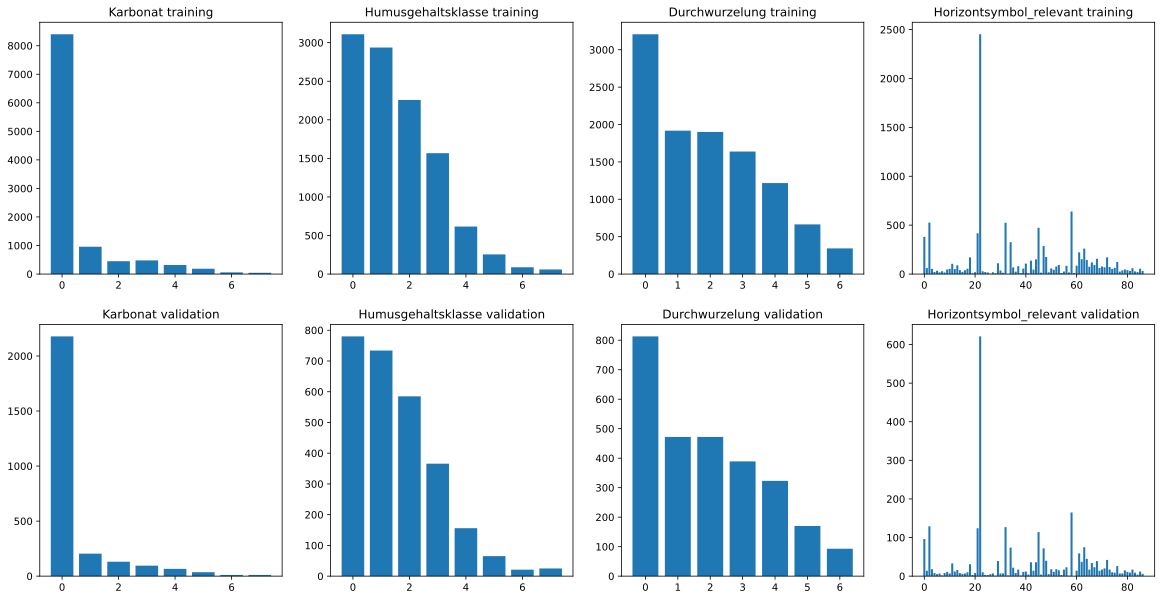

In [6]:
# If already computed, load the HCE embeddings for the labels (see Label_Graph.ipynb)
with open('./BGR/label_embeddings/all_horizons_embeddings.pickle', 'rb') as handle:
    emb_dict = pickle.load(handle)

plt.figure(figsize=(20, 10))
for i, (tab_feature, tab_predictor) in enumerate(zip(list(dataprocessor.stratified_split_targets), list(tabular_predictors_dict.keys())[1:] + ['Horizon_Predictor'])):
    if tab_predictor == 'Horizon_Predictor':
        num_cls = emb_dict['embedding'].shape[0]
    else:
        num_cls = tabular_predictors_dict[tab_predictor]['output_dim']
    for _ in range(num_cls):
        counts_train = train_df[tab_feature].explode().value_counts().reindex(np.arange(num_cls), fill_value=0)
        counts_val   = val_df[tab_feature].explode().value_counts().reindex(np.arange(num_cls), fill_value=0)

    plt.subplot(2, 4, i+1)
    plt.bar(list(range(num_cls)), list(counts_train.values))
    plt.title(tab_feature + ' training')
    plt.subplot(2, 4, i+5)
    plt.bar(list(range(num_cls)), list(counts_val.values))
    plt.title(tab_feature + ' validation')
plt.show()

In [7]:
# Get the lengths of the lists in the 'Untergrenze' column
list_lengths = df['Untergrenze'].apply(len)

min_length = list_lengths.min()
max_length = list_lengths.max()

print(f"Minimum number of horizons: {min_length}")
print(f"Maximum number of horizons: {max_length}")

Minimum number of horizons: 2
Maximum number of horizons: 8


In [8]:
min_length_list = df[df['Untergrenze'].apply(len) == min_length]['Untergrenze'].values[0]
max_length_list = df[df['Untergrenze'].apply(len) == max_length]['Untergrenze'].values[0]
print(f"List with minimum length: {min_length_list}")
print(f"List with maximum length: {max_length_list}")

List with minimum length: [0.32, 1.0]
List with maximum length: [0.13, 0.26, 0.4, 0.58, 0.68, 0.83, 0.98, 1.0]


In [9]:
# Define the image normalization
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet statistics
])

In [10]:
# Note: year and month should be handled differently
geotemp_categ = list(set(dataprocessor.categ_features).intersection(set(dataprocessor.geotemp_img_infos)))
# Get new number of geotemp columns
col_geotemp = [c for gt in dataprocessor.geotemp_img_infos for c in df.columns if c.startswith(gt)]

In [11]:
# Initialize model
#num_classes = len(df[target].unique()) # for one-hot encoding
#num_classes = emb_dict['embedding'].shape[1] # for HCE (the dim. of final layer in the model should match the dim of the embedded label vectors)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = bgr_mod.HorizonClassifier(geo_temp_input_dim=len(col_geotemp)-2,       # without counting the img path and index
                                  geo_temp_output_dim=256,
                                  max_seq_len = max_length,                    # fixed from longest list of horizons in one image from dataset
                                  stop_token=1.0,                              # End of Sequence Token at -1 meters
                                  #transformer_dim=128,
                                  #num_transformer_heads=4,
                                  #num_transformer_layers=2,
                                  rnn_hidden_dim=256,
                                  tabular_predictors_dict=tabular_predictors_dict, # for constructing the tabular predictors
                                  embedding_dim=np.shape(emb_dict['embedding'])[1], # dimension of the graph embedded vectors
                                  device=device)
model.to(device)

/storage/projects/BGR Soil/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/storage/projects/BGR Soil/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


HorizonClassifier(
  (image_encoder): ResNetEncoder(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [12]:
# Data split
#train_df, val_df = train_test_split(df, stratify=df[target], random_state=2024)
#train_df, val_df = train_test_split(df, random_state=2024) # ToDo: not stratified...

print(f'{len(train_df)} samples for training.')
print(f'{len(val_df)} samples for validating.')

2677 samples for training.
670 samples for validating.


In [13]:
# Define the image transforms for augmentation
augment = [
    #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    #transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1., 3.))
    VerticalStripeCrop(stripe_width_range=(150, 200)),
    VerticalStripeCrop(stripe_width_range=(100, 150))
]

In [14]:
batch_size = 64
# Create Dataset object with image and tabular features
train_dataset = ImageTabularDataset(dataframe=train_df,
                                             normalize=normalize,
                                             augment=augment,
                                             image_path='file',
                                             label=None, # no label column as input; access it instead via 'index' during training
                                             feature_columns=col_geotemp[:-1]) # without 'file'

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16,
                          drop_last=True) # any better idea than drop_last? without it, tensors don't get concatenated properly

# Training parameters
lr, reg = 1e-3, 1e-3
#lr, reg = 1e-4, 1e-4
#lr, reg = 1e-4, 1e-2
#lr, reg = 1e-5, 1e-1
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg)

depth_loss = DepthMarkerLoss(lambda_mono=0.0, lambda_div=0.0)
# All the tabular classifiers get a CE loss, all regressors get MSE
soil_losses = {}
for tab_predictor in tabular_predictors_dict:
    if tabular_predictors_dict[tab_predictor]['classification']:
        soil_losses[tab_predictor] = nn.CrossEntropyLoss()
    else:
        soil_losses[tab_predictor] = nn.MSELoss()

horizon_loss = nn.CosineEmbeddingLoss() # for HCE: 1 - cos(prediction, target)
horizon_acc = TopKHorizonAccuracy(torch.tensor(emb_dict['embedding'], device=device).float(), k=1)
hor_k = 5
horizon_topk_acc = TopKHorizonAccuracy(torch.tensor(emb_dict['embedding'], device=device).float(), k=hor_k)

In [15]:
### Callbacks
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.1, min_lr=lr*0.01, verbose=True)
scheduler = torch.optim.swa_utils.SWALR(optimizer, anneal_strategy='linear', anneal_epochs=20, swa_lr=lr*0.01)
early_stopping = EarlyStopping(patience=10, min_delta=0.01, verbose=True) # looks at val_loss (see callbacks.py)
model_name = 'lstm_depthmarker_resnet_seg_mlp_tabular_stones_carb_humus_root_hor_emb'
#checkpoint = ModelCheckpoint(save_path='./BGR/models/lstm_depthmarker.pth', monitor='avg_val_loss', mode='min', verbose=True)
#checkpoint = ModelCheckpoint(save_path='./BGR/models/lstm_depthmarker_mlp_tabular_stones_humus.pth',
#                             monitor='avg_val_loss', mode='min', verbose=True)
checkpoint = ModelCheckpoint(save_path='./BGR/models/' + model_name + '.pth', monitor='avg_val_loss', mode='min', verbose=True)

In [16]:
print(f"Training size original: {len(train_dataset.dataframe)}")
print(f"Training size after augmentation: {len(train_dataset)}")

Training size original: 2677
Training size after augmentation: 8031


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


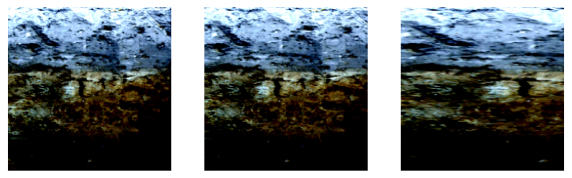

In [17]:
# Check an augmented subset
if augment:
    aug_images = []
    for i in range(len(train_dataset)):
        image, tabular_features = train_dataset[i]
        aug_images.append(image)
        #print(f"Image {i}")
        #print(tabular_features)
        if i == 2: break

    plt.figure(figsize=(10, 8))
    for i in range(len(aug_images)):
        plt.subplot(1, 3, i+1)
        plt.imshow(aug_images[i].swapaxes(0,2).swapaxes(0,1)) # returned shape is (c, h, w)
        plt.axis('off')

In [18]:
val_dataset = ImageTabularDataset(dataframe=val_df,
                                           normalize=normalize,
                                           image_path='file',
                                           label=None,
                                           feature_columns=col_geotemp[:-1]) # without 'file'

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=16, drop_last=True)

In [19]:
epochs = 20
lr_history, train_loss_history, val_loss_history = [], [], []
train_depth_loss_history, train_stones_loss_history, train_carb_loss_history, train_humus_loss_history, train_root_loss_history = [], [], [], [], []
val_depth_loss_history, val_stones_loss_history, val_carb_loss_history, val_humus_loss_history, val_root_loss_history = [], [], [], [], []
train_horizon_loss_history, val_horizon_loss_history = [], []
train_carb_acc_history, train_humus_acc_history, train_root_acc_history = [], [], []
val_carb_acc_history, val_humus_acc_history, val_root_acc_history = [], [], []
train_horizon_acc_history, val_horizon_acc_history = [], []
train_horizon_topk_acc_history, val_horizon_topk_acc_history = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Training loop
    model.train() # Important: reset the model in training mode at the beginning of every epoch
    train_depth_loss_total = 0.0
    train_stones_loss_total, train_carb_loss_total, train_humus_loss_total, train_root_loss_total = 0.0, 0.0, 0.0, 0.0
    train_horizon_loss_total = 0.0
    train_loss_total = 0.0
    train_carb_correct, train_humus_correct, train_root_correct, train_horizon_correct, train_horizon_topk_correct = 0, 0, 0, 0.0, 0.0
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for batch in train_loader_tqdm:
        images, geotemp_features = batch
        images, geotemp_features = images.to(device), geotemp_features.to(device)

        optimizer.zero_grad() # otherwise, PyTorch accumulates the gradients during backprop

        # Get corresponding true depth markers and morphological features via index column in df (the first value in every row in geotemp)
        # Note: the code accounts for duplicate indexes resulting after the augmentations in the ImageTabularDataset class (is there a better way than duplicating indexes during augmentation?)
        true_depths = []
        true_stones, true_carb, true_humus, true_root = [], [], [], []
        true_hor_emb_inds = []
        batch_indices = geotemp_features.cpu().numpy()[:, 0]
        for idx in batch_indices:
            true_depths.append( df.loc[df['index'] == idx, 'Untergrenze'].values[0] )
            true_stones.append( torch.tensor(df.loc[df['index'] == idx, 'Steine'].values[0]) )
            true_carb.append( torch.tensor(df.loc[df['index'] == idx, 'Karbonat'].values[0]) )
            true_humus.append( torch.tensor(df.loc[df['index'] == idx, 'Humusgehaltsklasse'].values[0]) )
            true_root.append( torch.tensor(df.loc[df['index'] == idx, 'Durchwurzelung'].values[0]) )
            true_hor_emb_inds.append( torch.tensor(df.loc[df['index'] == idx, 'Horizontsymbol_relevant'].values[0]) )
        true_stones  = torch.stack([item for sublist in true_stones for item in sublist], dim=0).to(device)
        true_carb    = torch.stack([item for sublist in true_carb for item in sublist], dim=0).to(device)
        true_humus   = torch.stack([item for sublist in true_humus for item in sublist], dim=0).to(device)
        true_root    = torch.stack([item for sublist in true_root for item in sublist], dim=0).to(device)
        true_hor_emb_inds = torch.stack([item for sublist in true_hor_emb_inds for item in sublist], dim=0).to(device)

        # Turn list of depths into a padded tensor and also return mask of valid positions
        padded_true_depths = pad_tensor(true_depths,
                                        max_seq_len=model.depth_marker_predictor.max_seq_len,
                                        stop_token=model.depth_marker_predictor.stop_token,
                                        device=device)

        # Predict depth markers (as padded tensors) and morphological features (only pred_stones is a number from regression, the rest are softmax)
        pred_depths, tabular_predictions, pred_hor_emb = model(images=images, geo_temp=geotemp_features[:, 1:], # 'index' column not used in model
                                                               true_depths=true_depths) # use ground truth depths during training for concatenation with image-geotemp vector (padded_true_depths needed for LSTMTabular)

        # Get the corresponding true embedded vectors according to the true indexes
        true_hor_emb = torch.tensor(emb_dict['embedding'], device=device)[true_hor_emb_inds]
        # Normalize predicted embeddings (the cosine loss doesn't do it automatically)
        # True embeddings were already normalized when computing them in Label_Graph.ipynb
        pred_hor_emb = F.normalize(pred_hor_emb, p=2, dim=1)
        # Create a dummy "same class" tensor with 1s for the cosine similarity
        same_class = torch.ones(pred_hor_emb.size(0)).to(device)

        # Compute individual losses, then sum them together for backprop
        train_depth_loss = depth_loss(pred_depths, padded_true_depths)
        train_stones_loss = soil_losses['Stones_Predictor'](tabular_predictions['Stones_Predictor'], true_stones)
        train_carb_loss = soil_losses['Carbonate_Predictor'](tabular_predictions['Carbonate_Predictor'], true_carb)
        train_humus_loss  = soil_losses['Humus_Predictor'](tabular_predictions['Humus_Predictor'], true_humus)
        train_root_loss = soil_losses['Rooting_Predictor'](tabular_predictions['Rooting_Predictor'], true_root)
        train_horizon_loss = horizon_loss(pred_hor_emb, true_hor_emb, same_class)

        train_loss = train_depth_loss + train_stones_loss + train_carb_loss + train_humus_loss + train_root_loss + train_horizon_loss
        # Note: any reason to weight the losses differently?

        train_loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Calculate batch losses to total loss
        train_depth_loss_total += train_depth_loss.item()
        train_stones_loss_total += train_stones_loss.item()
        train_carb_loss_total += train_carb_loss.item()
        train_humus_loss_total += train_humus_loss.item()
        train_root_loss_total += train_root_loss.item()
        train_horizon_loss_total += train_horizon_loss.item()
        train_loss_total += train_loss.item()

        # Calculate accuracies for categorical tabular features
        train_carb_correct += (torch.argmax(tabular_predictions['Carbonate_Predictor'], 1) == true_carb).float().mean().item()
        train_humus_correct += (torch.argmax(tabular_predictions['Humus_Predictor'], 1) == true_humus).float().mean().item()
        train_root_correct += (torch.argmax(tabular_predictions['Rooting_Predictor'], 1) == true_root).float().mean().item()

        # Calculate accuracy for horizon label (top 1 = the closest embedding vector to the predicted one)
        train_horizon_correct += horizon_acc(pred_hor_emb, true_hor_emb_inds)
        train_horizon_topk_correct += horizon_topk_acc(pred_hor_emb, true_hor_emb_inds)

        train_loader_tqdm.set_postfix(loss=train_loss.item())

    # Average losses and accuracies at the end of the epoch
    avg_train_depth_loss = train_depth_loss_total / len(train_loader) # divide by number of batches
    avg_train_stones_loss = train_stones_loss_total / len(train_loader)
    avg_train_carb_loss = train_carb_loss_total / len(train_loader)
    avg_train_humus_loss = train_humus_loss_total / len(train_loader)
    avg_train_root_loss = train_root_loss_total / len(train_loader)
    avg_train_horizon_loss = train_horizon_loss_total / len(train_loader)
    avg_train_loss = train_loss_total / len(train_loader)

    train_carb_acc = train_carb_correct / len(train_loader)
    train_humus_acc = train_humus_correct / len(train_loader)
    train_root_acc = train_root_correct / len(train_loader)
    train_horizon_acc = train_horizon_correct / len(train_loader) # divide by number of batches, since TopKHorizonAccuracy returns a batch mean
    train_horizon_topk_acc = train_horizon_topk_correct / len(train_loader)
    # Note: because of shuffle and drop_last, the training set has a slightly different number of horizons in every epoch (same applies for val_set).
    # The difference is, however, negligible (~10 horizons out of 30k in training).

    # Evaluation loop
    model.eval() # Set model in evaluation mode before running inference
    val_depth_loss_total = 0.0
    val_stones_loss_total, val_carb_loss_total, val_humus_loss_total, val_root_loss_total = 0.0, 0.0, 0.0, 0.0
    val_horizon_loss_total = 0.0
    val_loss_total = 0.0
    val_carb_correct, val_humus_correct, val_root_correct, val_horizon_correct, val_horizon_topk_correct = 0, 0, 0, 0.0, 0.0
    val_loader_tqdm = tqdm(val_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in val_loader_tqdm:
            images, geotemp_features = batch
            images, geotemp_features = images.to(device), geotemp_features.to(device)

            # Get corresponding true depth markers via index column in df (see training step above)
            true_depths = []
            true_stones, true_carb, true_humus, true_root = [], [], [], []
            true_hor_emb_inds = []
            batch_indices = geotemp_features.cpu().numpy()[:, 0]
            for idx in batch_indices:
                true_depths.append( df.loc[df['index'] == idx, 'Untergrenze'].values[0] )
                true_stones.append( torch.tensor(df.loc[df['index'] == idx, 'Steine'].values[0]) )
                true_carb.append( torch.tensor(df.loc[df['index'] == idx, 'Karbonat'].values[0]) )
                true_humus.append( torch.tensor(df.loc[df['index'] == idx, 'Humusgehaltsklasse'].values[0]) )
                true_root.append( torch.tensor(df.loc[df['index'] == idx, 'Durchwurzelung'].values[0]) )
                true_hor_emb_inds.append( torch.tensor(df.loc[df['index'] == idx, 'Horizontsymbol_relevant'].values[0]) )
            true_stones  = torch.stack([item for sublist in true_stones for item in sublist], dim=0).to(device)
            true_carb    = torch.stack([item for sublist in true_carb for item in sublist], dim=0).to(device)
            true_humus   = torch.stack([item for sublist in true_humus for item in sublist], dim=0).to(device)
            true_root    = torch.stack([item for sublist in true_root for item in sublist], dim=0).to(device)
            true_hor_emb_inds = torch.stack([item for sublist in true_hor_emb_inds for item in sublist], dim=0).to(device)

            # Turn list of depths into a padded tensor and also return mask of valid positions
            padded_true_depths = pad_tensor(true_depths,
                                            max_seq_len=model.depth_marker_predictor.max_seq_len,
                                            stop_token=model.depth_marker_predictor.stop_token,
                                            device=device)

            # Predict depth markers (as padded tensors) and morphological features
            pred_depths, tabular_predictions, pred_hor_emb = model(images=images, geo_temp=geotemp_features[:, 1:], # 'index' column not used in model
                                                                   true_depths=true_depths)
            # Note: should we use the model's predicted depths here?
            # But then there can be a mismatch between the number of true tabular labels and the ones that can be predicted...

            # Get the corresponding true embedded vectors according to the true indexes
            true_hor_emb = torch.tensor(emb_dict['embedding'], device=device)[true_hor_emb_inds]
            # Normalize predicted embeddings (the cosine loss doesn't do it automatically)
            # True embeddings were already normalized when computing them in Label_Graph.ipynb
            pred_hor_emb = F.normalize(pred_hor_emb, p=2, dim=1)
            # Create a dummy "same class" tensor with 1s for the cosine similarity
            same_class = torch.ones(pred_hor_emb.size(0)).to(device)

            # Get the corresponding true embedded vectors according to the true indexes
            true_hor_emb = torch.tensor(emb_dict['embedding'], device=device)[true_hor_emb_inds]

            # Compute batch losses
            val_depth_loss = depth_loss(pred_depths, padded_true_depths)
            val_stones_loss = soil_losses['Stones_Predictor'](tabular_predictions['Stones_Predictor'], true_stones)
            val_carb_loss = soil_losses['Carbonate_Predictor'](tabular_predictions['Carbonate_Predictor'], true_carb)
            val_humus_loss  = soil_losses['Humus_Predictor'](tabular_predictions['Humus_Predictor'], true_humus)
            val_root_loss = soil_losses['Rooting_Predictor'](tabular_predictions['Rooting_Predictor'], true_root)
            val_horizon_loss = horizon_loss(pred_hor_emb, true_hor_emb, same_class)

            val_loss = val_depth_loss + val_stones_loss + val_carb_loss + val_humus_loss + val_root_loss + val_horizon_loss

            # Add batch losses to total loss
            val_depth_loss_total += val_depth_loss.item()
            val_stones_loss_total += val_stones_loss.item()
            val_carb_loss_total += val_carb_loss.item()
            val_humus_loss_total += val_humus_loss.item()
            val_root_loss_total += val_root_loss.item()
            val_horizon_loss_total += val_horizon_loss.item()
            val_loss_total += val_loss.item()

            # Calculate accuracies for categorical tabular features
            val_carb_correct += (torch.argmax(tabular_predictions['Carbonate_Predictor'], 1) == true_carb).float().mean().item()
            val_humus_correct += (torch.argmax(tabular_predictions['Humus_Predictor'], 1) == true_humus).float().mean().item()
            val_root_correct += (torch.argmax(tabular_predictions['Rooting_Predictor'], 1) == true_root).float().mean().item()

            # Calculate accuracy for horizon label (top 1 = the closest embedding vector to the predicted one)
            val_horizon_correct += horizon_acc(pred_hor_emb, true_hor_emb_inds)
            val_horizon_topk_correct += horizon_topk_acc(pred_hor_emb, true_hor_emb_inds)

    # Average losses and accuracies at the end of the epoch
    avg_val_depth_loss = val_depth_loss_total / len(val_loader) # divide by number of batches
    avg_val_stones_loss = val_stones_loss_total / len(val_loader)
    avg_val_carb_loss = val_carb_loss_total / len(val_loader)
    avg_val_humus_loss = val_humus_loss_total / len(val_loader)
    avg_val_root_loss = val_root_loss_total / len(val_loader)
    avg_val_horizon_loss = val_horizon_loss_total / len(val_loader)
    avg_val_loss = val_loss_total / len(val_loader)

    val_carb_acc = val_carb_correct / len(val_loader)
    val_humus_acc = val_humus_correct / len(val_loader)
    val_root_acc = val_root_correct / len(val_loader)
    val_horizon_acc = val_horizon_correct / len(val_loader) # divide by number of batches, since TopKHorizonAccuracy returns
    val_horizon_topk_acc = val_horizon_topk_correct / len(val_loader)

    # Save checkpoint if validation loss is at an optimum
    checkpoint(model, avg_val_loss)
    # Apply the scheduler with validation loss
    #scheduler.step(avg_val_loss)
    scheduler.step() # SWA
    # Log the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)

    # Log metrics
    train_loss_history.append(avg_train_loss); val_loss_history.append(avg_val_loss)
    train_depth_loss_history.append(avg_train_depth_loss); val_depth_loss_history.append(avg_val_depth_loss)
    train_stones_loss_history.append(avg_train_stones_loss); val_stones_loss_history.append(avg_val_stones_loss)
    train_carb_loss_history.append(avg_train_carb_loss); val_carb_loss_history.append(avg_val_carb_loss)
    train_humus_loss_history.append(avg_train_humus_loss); val_humus_loss_history.append(avg_val_humus_loss)
    train_root_loss_history.append(avg_train_root_loss); val_root_loss_history.append(avg_val_root_loss)
    train_horizon_loss_history.append(avg_train_horizon_loss); val_horizon_loss_history.append(avg_val_horizon_loss)

    train_carb_acc_history.append(train_carb_acc); val_carb_acc_history.append(val_carb_acc)
    train_humus_acc_history.append(train_humus_acc); val_humus_acc_history.append(val_humus_acc)
    train_root_acc_history.append(train_root_acc); val_root_acc_history.append(val_root_acc)
    train_horizon_acc_history.append(train_horizon_acc); val_horizon_acc_history.append(val_horizon_acc)
    train_horizon_topk_acc_history.append(train_horizon_topk_acc); val_horizon_topk_acc_history.append(val_horizon_topk_acc)

    print(f"Epoch {epoch+1}, Total Training Loss: {avg_train_loss:.4f}")
    print(f"Depth Loss: {avg_train_depth_loss:.4f}")
    print(f"Stones Loss: {avg_train_stones_loss:.4f}")
    print(f"Carb Loss: {avg_train_carb_loss:.4f}, Carb Accuracy: {train_carb_acc:.4f}")
    print(f"Humus Loss: {avg_train_humus_loss:.4f}, Humus Accuracy: {train_humus_acc:.4f}")
    print(f"Root Loss: {avg_train_root_loss:.4f}, Root Accuracy: {train_root_acc:.4f}")
    print(f"Horizon Loss: {avg_train_horizon_loss:.4f}, Horizon Accuracy: {train_horizon_acc:.4f}, Horizon Top-{hor_k} Accuracy: {train_horizon_topk_acc:.4f}")
    print(f"\nTotal Validation Loss: {avg_val_loss:.4f}")
    print(f"Depth Loss: {avg_val_depth_loss:.4f}")
    print(f"Stones Loss: {avg_val_stones_loss:.4f}")
    print(f"Carb Loss: {avg_val_carb_loss:.4f}, Carb Accuracy: {val_carb_acc:.4f}")
    print(f"Humus Loss: {avg_val_humus_loss:.4f}, Humus Accuracy: {val_humus_acc:.4f}")
    print(f"Root Loss: {avg_val_root_loss:.4f}, Root Accuracy: {val_root_acc:.4f}")
    print(f"Horizon Loss: {avg_val_horizon_loss:.4f}, Horizon Accuracy: {val_horizon_acc:.4f}, Horizon Top-{hor_k} Accuracy: {val_horizon_topk_acc:.4f}")
    print(f"Current LR: {current_lr}")

    # Early stopping check
    early_stopping(avg_val_loss)
    if early_stopping.should_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1/20


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Model checkpoint saved at './BGR/models/lstm_depthmarker_resnet_seg_mlp_tabular_stones_carb_humus_root_hor_emb.pth' with avg_val_loss: 7.0340
Epoch 1, Total Training Loss: 4.1839
Depth Loss: 0.0231
Stones Loss: 0.1229
Carb Loss: 0.7142, Carb Accuracy: 0.7894
Humus Loss: 1.2260, Humus Accuracy: 0.5158
Root Loss: 1.6754, Root Accuracy: 0.3262
Horizon Loss: 0.4223, Horizon Accuracy: 0.3076, Horizon Top-5 Accuracy: 0.5369

Total Validation Loss: 7.0340
Depth Loss: 0.0123
Stones Loss: 0.0909
Carb Loss: 0.7550, Carb Accuracy: 0.8158
Humus Loss: 3.1506, Humus Accuracy: 0.2728
Root Loss: 2.4077, Root Accuracy: 0.2757
Horizon Loss: 0.6177, Horizon Accuracy: 0.1761, Horizon Top-5 Accuracy: 0.3485
Current LR: 0.0009505
Epoch 2/20


Model checkpoint saved at './BGR/models/lstm_depthmarker_resnet_seg_mlp_tabular_stones_carb_humus_root_hor_emb.pth' with avg_val_loss: 4.5499
Epoch 2, Total Training Loss: 3.2888
Depth Loss: 0.0104
Stones Loss: 0.0282
Carb Loss: 0.5262, Carb Accuracy: 0.8281
Humus Loss: 0.9194, Humus Accuracy: 0.6287
Root Loss: 1.5081, Root Accuracy: 0.4006
Horizon Loss: 0.2963, Horizon Accuracy: 0.4261, Horizon Top-5 Accuracy: 0.6891

Total Validation Loss: 4.5499
Depth Loss: 0.0126
Stones Loss: 0.0240
Carb Loss: 0.6483, Carb Accuracy: 0.8136
Humus Loss: 1.5858, Humus Accuracy: 0.3593
Root Loss: 1.7292, Root Accuracy: 0.2851
Horizon Loss: 0.5499, Horizon Accuracy: 0.1706, Horizon Top-5 Accuracy: 0.3668
Current LR: 0.0009010000000000001
Epoch 3/20


KeyboardInterrupt: 

### Evaluation

In [ ]:
# Depths-LSTM check
for true_dep, pred_dep in zip(padded_true_depths, pred_depths):
    print('True:')
    print(true_dep)
    print('Predicted:')
    print(pred_dep)
    print(' ')

True:
tensor([0.3300, 0.4800, 0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
Predicted:
tensor([0.3448, 0.5489, 0.7891, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
 
True:
tensor([0.3300, 0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
Predicted:
tensor([0.2786, 0.6105, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
 
True:
tensor([0.3000, 0.6600, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
Predicted:
tensor([0.2745, 0.4766, 0.7896, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
 
True:
tensor([0.1000, 0.3000, 0.5000, 0.7000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
Predicted:
tensor([0.1253, 0.3106, 0.5442, 0.8595, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
 
True:
tensor([0.3400, 0.5000, 0.6800, 0.9600, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
Predicted:
tensor([0.3361, 0.5267, 0.7784, 1.

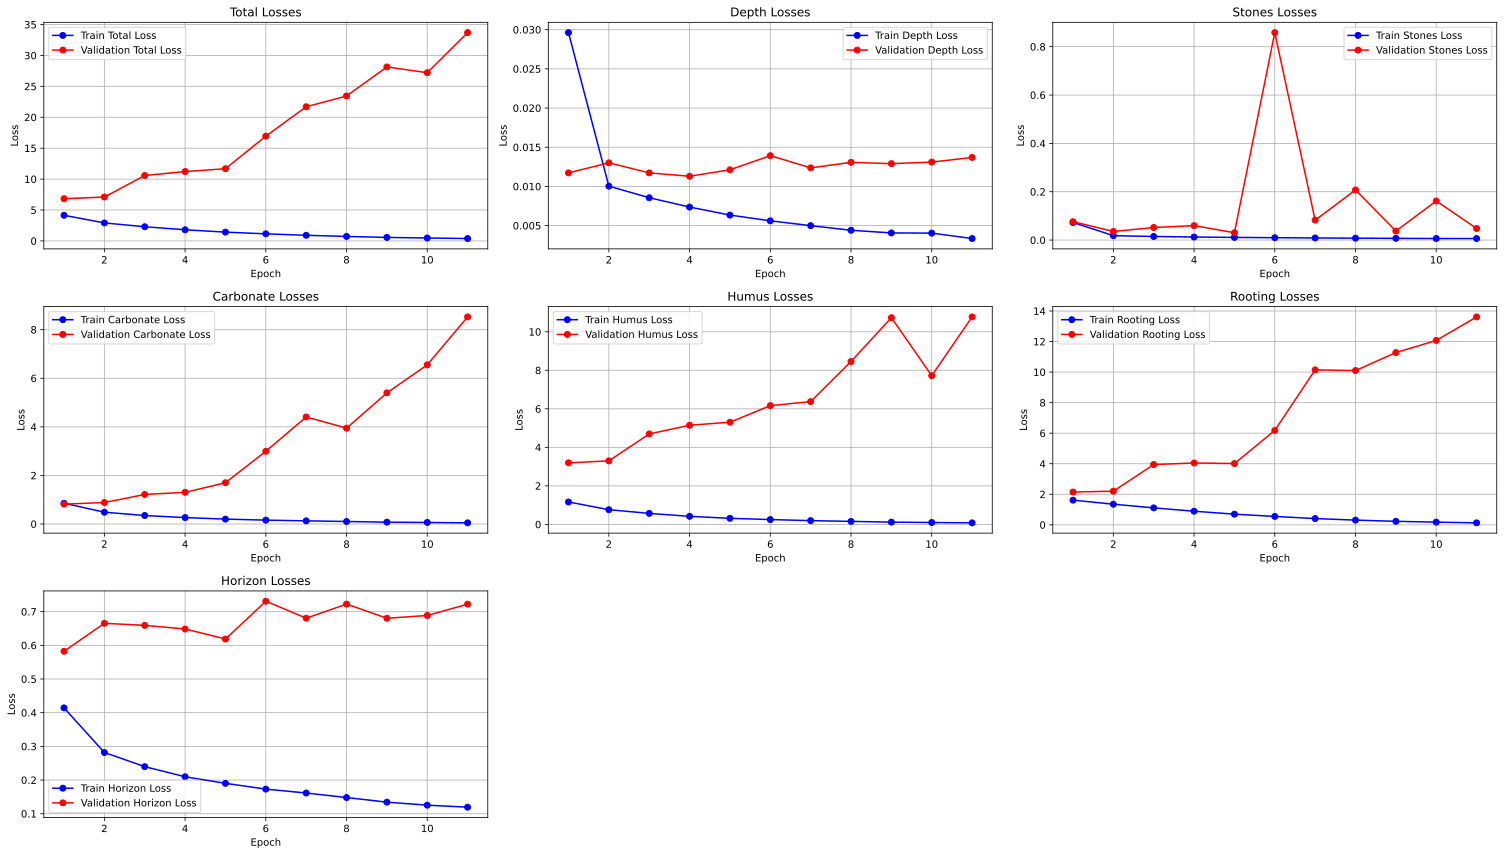

In [ ]:
complete_epochs = len(train_loss_history) + 1
loss_histories = {
    'Total': (train_loss_history, val_loss_history),
    'Depth': (train_depth_loss_history, val_depth_loss_history),
    'Stones': (train_stones_loss_history, val_stones_loss_history),
    'Carbonate': (train_carb_loss_history, val_carb_loss_history),
    'Humus': (train_humus_loss_history, val_humus_loss_history),
    'Rooting': (train_root_loss_history, val_root_loss_history),
    'Horizon': (train_horizon_loss_history, val_horizon_loss_history),
}

plt.figure(figsize=(21, 12))
for i, (title, (train_history, val_history)) in enumerate(loss_histories.items()):
    plt.subplot(3, 3, i + 1)
    plt.plot(range(1, complete_epochs), train_history, label=f'Train {title} Loss', marker='o', color='b')
    plt.plot(range(1, complete_epochs), val_history, label=f'Validation {title} Loss', marker='o', color='r')
    plt.title(f'{title} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

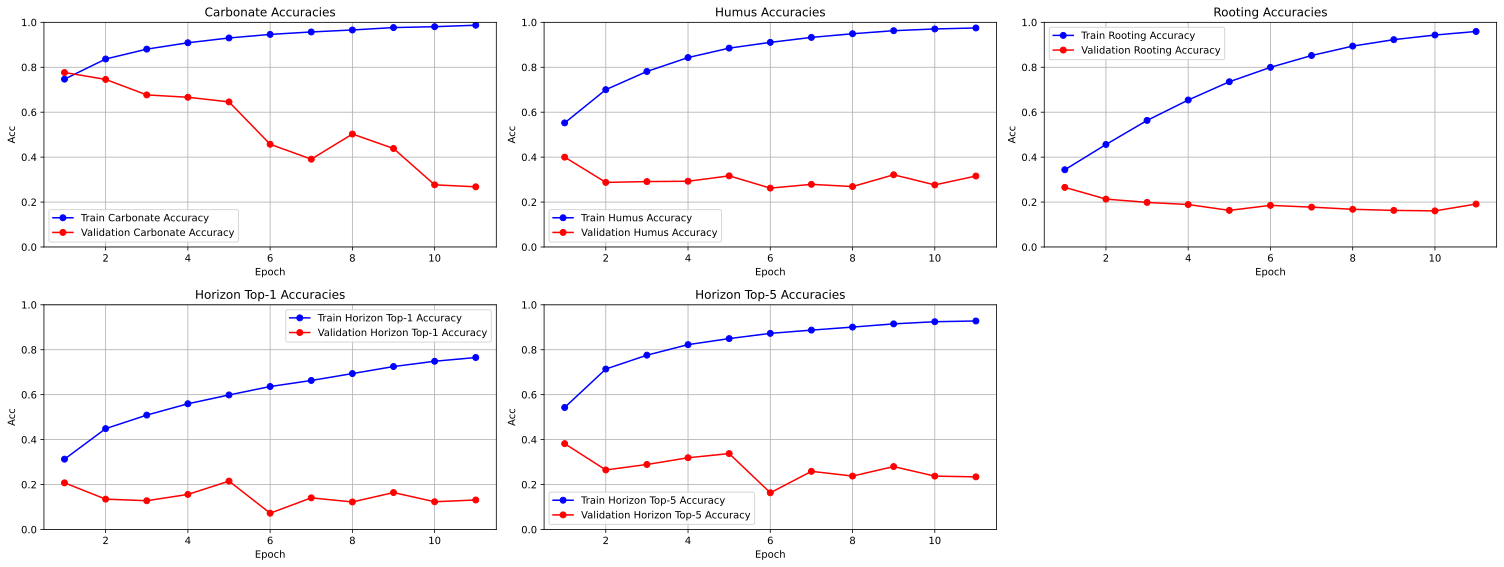

In [ ]:
acc_histories = {
    'Carbonate': (train_carb_acc_history, val_carb_acc_history),
    'Humus': (train_humus_acc_history, val_humus_acc_history),
    'Rooting': (train_root_acc_history, val_root_acc_history),
    'Horizon Top-1': (train_horizon_acc_history, val_horizon_acc_history),
    f'Horizon Top-{hor_k}': (train_horizon_topk_acc_history, val_horizon_topk_acc_history),
}

plt.figure(figsize=(21, 8))
for i, (title, (train_history, val_history)) in enumerate(acc_histories.items()):
    plt.subplot(2, 3, i + 1)
    plt.plot(range(1, complete_epochs), train_history, label=f'Train {title} Accuracy', marker='o', color='b')
    plt.plot(range(1, complete_epochs), val_history, label=f'Validation {title} Accuracy', marker='o', color='r')
    plt.title(f'{title} Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.ylim([0.0, 1.0])
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
history_data = {
    'train_loss': train_loss_history,
    'val_loss': val_loss_history,
    'train_depth_loss': train_depth_loss_history,
    'val_depth_loss': val_depth_loss_history,
    'train_stones_loss': train_stones_loss_history,
    'val_stones_loss': val_stones_loss_history,
    'train_carb_loss': train_carb_loss_history,
    'val_carb_loss': val_carb_loss_history,
    'train_humus_loss': train_humus_loss_history,
    'val_humus_loss': val_humus_loss_history,
    'train_root_loss': train_root_loss_history,
    'val_root_loss': val_root_loss_history,
    'train_horizon_loss': train_horizon_loss_history,
    'val_horizon_loss': val_horizon_loss_history,
    'train_carb_acc': train_carb_acc_history,
    'val_carb_acc': val_carb_acc_history,
    'train_humus_acc': train_humus_acc_history,
    'val_humus_acc': val_humus_acc_history,
    'train_root_acc': train_root_acc_history,
    'val_root_acc': val_root_acc_history,
    'train_horizon_acc': train_horizon_acc_history,
    'val_horizon_acc': val_horizon_acc_history,
    'train_horizon_topk_acc': train_horizon_topk_acc_history,
    'val_horizon_topk_acc': val_horizon_topk_acc_history,
}

# Save the dictionary to a pickle file
with open('./BGR/figures/histories/' + model_name + '.pickle', 'wb') as f:
    pickle.dump(history_data, f)

In [ ]:
# Load history dictionary
with open('./BGR/figures/histories/' + model_name + '.pickle', 'rb') as handle:
    history_data = pickle.load(handle)